## Country-level INFRA-SAP

- Origins: Population grid (Worldpop downsampled to 500 meters)
- Destinations: Cities, airports, border crossings, and ports

Typical access analysis with two adjustments:
    1. Extract different sets of destinations from OD
    2. Join travel time to origin grid based on "NN with the fastest route" (not necessarily closest NN)

In [1]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import GOSTnets.calculate_od_raw as calcOD
from GOSTnets.load_osm import *
import rasterio as rio
from osgeo import gdal
import numpy as np
from shapely.geometry import Point

sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator

%load_ext autoreload
%autoreload 2

In [2]:
country = 'guatemala'
iso3 = 'GTM'
epsg = 26915

### Load origins and graph

In [3]:
base_in = "/home/public/Data/PROJECTS/INFRA_SAP"
in_folder = os.path.join(base_in, iso3)

# define data paths
focal_admin2 = os.path.join(in_folder, "admin.shp")
focal_osm = os.path.join(in_folder, f"{country}-latest.osm.pbf")
pop_name = "WP_2020_1km"
wp_1km = os.path.join(in_folder, f"{pop_name}.tif")
urban_extents = os.path.join(in_folder, "urban_extents.shp")
airports = os.path.join(in_folder, "airports.shp")
ports = os.path.join(in_folder, "ports.shp")
borders = os.path.join(in_folder, "borders.shp")

base_out = "/home/wb514197/data/INFRA_SAP" # GOT permission denied using public 
out_folder = os.path.join(base_out, iso3)
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

Convert **WP_2020_1km.tif** into a point GeoData frame

In [4]:
inDs = gdal.Open(wp_1km)
out_pop = os.path.join(out_folder, f"{pop_name}.xyz")
outDs = gdal.Translate(out_pop, inDs, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])
out_pop_csv = os.path.join(out_folder, f"{pop_name}.csv")
os.rename(out_pop, out_pop_csv)

In [5]:
wp_df = pd.read_csv(out_pop_csv, sep=' ')
wp_df.rename(columns={"Z":"Pop"}, inplace=True)
wp_df = wp_df.loc[wp_df.Pop!=-99999.0].copy()
geoms = [Point(xy) for xy in zip(wp_df.X, wp_df.Y)]
wp_df.drop(["X","Y"], axis=1, inplace=True)
crs = 'EPSG:4326'
origins = gpd.GeoDataFrame(wp_df, crs=crs, geometry=geoms)
origins['pointid'] = origins.index

### Prepare Graph

In [6]:
# G_path = None # if a graph already exists list the path here
G_path = os.path.join(in_folder, 'graph', f"G_{iso3}.pickle") 

In [7]:
if G_path is None:
    print("Creating graph from scratch")
    osm_raw = OSM_to_network(focal_osm)
    accepted_road_types = ['trunk','trunk_link','primary','primary_link','secondary','secondary_link','tertiary','tertiary_link']
    osm_raw.filterRoads(acceptedRoads = accepted_road_types)
    osm_raw.generateRoadsGDF(verbose = False)
    osm_raw.initialReadIn()
    
    if not os.path.exists(os.path.join(out_folder, 'graph')):
        os.mkdir(os.path.join(out_folder, 'graph'))
    gn.save(osm_raw.network,f'G_{iso3}_unclean',os.path.join(out_folder, 'graph'))
    
    #clean graph
    G_clean = gn.clean_network(osm_raw.network, UTM = f"EPSG:{epsg}", WGS = "EPSG:4326", junctdist = 50, verbose = False)
    G = G_clean.copy()

else:
    G = nx.read_gpickle(G_path)
    for u, v, data in G.edges(data = True):
        if type(data['Wkt']) == list:
            data['Wkt'] = gn.unbundle_geometry(data['Wkt'])

In [9]:
# Salt network
attr_list = ['id', 'infra_type', 'osm_id', 'key', 'Type']
G_salt = gn.salt_long_lines(G, source='EPSG:4326', target=f'EPSG:{epsg}', thresh=5000, factor=1000, attr_list=attr_list)
G_time = gn.convert_network_to_time(G_salt, distance_tag = 'length', road_col = 'infra_type', factor = 1000)
if not os.path.exists(os.path.join(out_folder, 'graph')):
    os.mkdir(os.path.join(out_folder, 'graph'))
gn.save(G_time, f"G_{iso3}_Salt", os.path.join(out_folder, 'graph'))

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When m

Identified 2664 unique edge(s) longer than 5000. 
Beginning new node creation...
15854 new edges added and 5333 removed to bring total edges to 36637
5263 new nodes added to bring total nodes to 14514


#### Select largest graph

In [10]:
list_of_subgraphs = [G_time.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G_time), key=len, reverse=True)]
G_largest = list_of_subgraphs[0]

### Prepare destinations

In [11]:
inCities = gpd.read_file(urban_extents)
pop_thresh=50000
inCities = inCities.loc[inCities.Pop>pop_thresh]
inCities['geometry'] = inCities.geometry.centroid
dest_cities = inCities.assign(dest_type = 'city')

In [12]:
dest_airports = gpd.read_file(airports)
dest_airports = dest_airports.assign(dest_type = 'airport')

In [13]:
dest_ports = gpd.read_file(ports).assign(dest_type = 'port')
dest_borders = gpd.read_file(borders).assign(dest_type = 'border')
dest_borders['geometry'] = dest_borders.geometry.apply(lambda x: x[0])

In [14]:
dest_all = pd.concat([dest_cities, dest_ports, dest_airports, dest_borders], ignore_index=True)

In [15]:
dest_all.dest_type.value_counts()

airport    50
border     28
city       16
port        2
Name: dest_type, dtype: int64

In [16]:
dest_all.to_csv(os.path.join(out_folder, 'destination_all.csv'))

In [17]:
len(origins), len(dest_all)

(133659, 96)

### Snap origins and destinations

#### Snap to origins to 5 nearest nodes

In [18]:
utm = f"EPSG:{epsg}"

In [19]:
%%time
# this function returns a dictionary of origin IDs, with a list of 5 NNs, and a corresponding list of distances
origins_snapped_dict = gn.pandana_snap_to_many(G_largest, origins, source_crs='epsg:4326', target_crs=utm, 
                                               add_dist_to_node_col = True, k_nearest=5, origin_id='pointid')

CPU times: user 20.8 s, sys: 175 ms, total: 21 s
Wall time: 21 s


In [20]:
dest_snapped = gn.pandana_snap_c(G_largest, dest_all, source_crs='epsg:4326', target_crs=utm,
                                 add_dist_to_node_col = False)

In [21]:
dest_nn = list(dest_snapped['NN'])
list_origins_NN = []
for each in origins_snapped_dict.values():
    list_origins_NN += each['NN']
origins_unique_nn = list(set(list_origins_NN))

In [22]:
%%time
curOD = gn.calculate_OD(G_largest, origins_unique_nn, dest_nn, fail_value = 999999999)

CPU times: user 5.52 s, sys: 977 µs, total: 5.52 s
Wall time: 5.52 s


quick checks

In [23]:
curOD[curOD==999999999]

array([], dtype=float64)

In [24]:
curOD.shape

(5703, 96)

In [25]:
od_df = pd.DataFrame(curOD, index=origins_unique_nn, columns=dest_nn)

In [26]:
od_df.head()

,new_obj_5260,new_obj_4782,5314_649_1937,25191,new_obj_4446_2635_7840,5313_646_1922,32423,30920,new_obj_3102,11722,...,9240_1094_3290,9240_1094_3290,new_obj_5335,new_obj_5335,new_obj_5335,new_obj_5335,new_obj_3954_2614_7785,new_obj_3954_2614_7785,new_obj_3954_2614_7785,new_obj_3954_2614_7785
14884_1628_4916,24445.533440,48182.827774,51590.273879,48037.195567,43152.974353,52096.865363,59953.742028,56969.152366,61019.240251,63463.933082,...,62534.434670,62534.434670,33245.969156,33245.969156,33245.969156,33245.969156,59043.325727,59043.325727,59043.325727,59043.325727
5,52862.055387,41443.178535,25105.566035,21265.764610,29643.155670,17319.985385,13556.356640,30678.137342,24188.296568,8347.919108,...,33671.370821,33671.370821,61662.491103,61662.491103,61662.491103,61662.491103,13819.513182,13819.513182,13819.513182,13819.513182
new_obj_3358_1601_4839,50883.584009,43068.287010,23127.094657,19287.293232,27664.684292,15341.514006,6576.485440,32303.245817,25813.405043,1368.047908,...,35296.479296,35296.479296,59684.019725,59684.019725,59684.019725,59684.019725,6839.641981,6839.641981,6839.641981,6839.641981
13,51291.029730,34261.251674,34603.813380,30924.136306,28036.674691,26151.185252,22557.116038,23496.210481,17006.369707,17348.678506,...,26489.443960,26489.443960,54988.108092,54988.108092,54988.108092,54988.108092,22820.272580,22820.272580,22820.272580,22820.272580
31,56609.592045,39579.813989,36300.924236,32461.122810,33355.237006,28515.343585,24094.102542,28814.772796,22324.932023,18885.665010,...,31808.006275,31808.006275,60306.670408,60306.670408,60306.670408,60306.670408,24357.259084,24357.259084,24357.259084,24357.259084


For each origin set of 5 (k) possible NN:
    - Add snapping dist (in time) + time to a destination
    - Which destination? min time from all of them won't necessarily work, so we need to find the closest destination for each origin, and select the NN which yields the fastest travel time to that dest
    - closest_dest.idx should match the OD column order.

In [27]:
%%time
closest_dest = gn.pandana_snap_points(origins, dest_all, source_crs='epsg:4326', target_crs=utm,
                                      add_dist_to_node_col=True)

CPU times: user 7.19 s, sys: 46 ms, total: 7.24 s
Wall time: 7.24 s


In [28]:
closest_dest = closest_dest.set_index('pointid')

In [29]:
closest_dest.head()

,Pop,geometry,idx,idx_dist
pointid,,,,
148,17.833401,POINT (713526.895 1970820.776),47,38167.960297
149,16.891191,POINT (714410.449 1970830.304),47,37662.112060
150,16.950291,POINT (715294.008 1970839.871),47,37170.417996
151,17.671246,POINT (716177.570 1970849.478),47,36693.447402
152,16.732470,POINT (717061.136 1970859.125),47,36231.782056


In [30]:
%%time
fastest_nn = []
fastest_dist = []
custom_speed = 30 # km/h

for pointid, items in origins_snapped_dict.items():
    dest_index = closest_dest.loc[pointid].idx
    nn_list = items['NN']
    dist_list = items['NN_dist']
    total_time_list = []
    for i in range(0, len(nn_list)):
        time_snapping = ((dist_list[i] / 1000) / custom_speed) * 60 * 60
        #time_to_dest = od_df.loc[nn_list[i]].min()
        time_to_dest = od_df.loc[nn_list[i]].iloc[dest_index]
        total_time = time_snapping+time_to_dest
        total_time_list.append(total_time)
#         print(f"id: {nn_list[i]}, snapping dist (km): {dist_list[i]/1000:.2f}, time to dest (min): {(total_time/60)/60:.2f}")
    min_pos = total_time_list.index(min(total_time_list))
    fastest_nn.append(nn_list[min_pos])
    fastest_dist.append(dist_list[min_pos])
#     origins_snapped_smart.loc[pointid, "NN"] = nn_list[min_pos]
#     origins_snapped_smart.loc[pointid, "NN_dist"] = dist_list[min_pos]

CPU times: user 1min 35s, sys: 27.8 ms, total: 1min 35s
Wall time: 1min 35s


In [31]:
origins_snapped = origins.copy().set_index('pointid')
origins_snapped['NN'] = pd.Series(fastest_nn, index = origins_snapped.index)
origins_snapped['NN_dist'] = pd.Series(fastest_dist, index = origins_snapped.index)
origins_snapped['pointid'] = origins_snapped.index
origins_snapped['NN_dist_seconds'] = ((origins_snapped.NN_dist / 1000) / custom_speed) * 60 * 60
origins_snapped['NN_dist_hours'] = ((origins_snapped.NN_dist / 1000) / custom_speed)

In [32]:
origins_snapped.head()

,Pop,geometry,NN,NN_dist,pointid,NN_dist_seconds,NN_dist_hours
pointid,,,,,,,
148,17.833401,POINT (-90.98542 17.81458),17979,7862.647847,148,943.517742,0.262088
149,16.891191,POINT (-90.97708 17.81458),17979,8727.086089,149,1047.250331,0.290903
150,16.950291,POINT (-90.96875 17.81458),17979,9595.014026,150,1151.401683,0.319834
151,17.671246,POINT (-90.96042 17.81458),23903,9940.660906,151,1192.879309,0.331355
152,16.732470,POINT (-90.95208 17.81458),7912_942_2811,10701.299317,152,1284.155918,0.356710


In [33]:
origins_join = origins_snapped.join(od_df, on='NN')

In [34]:
all(origins_join.columns[7:] == dest_snapped.NN)

True

In [35]:
origins_join_rename = origins_join.copy()
origins_join_rename.columns = pd.MultiIndex.from_arrays([['origin' for each in origins_snapped.columns]+list(dest_snapped.dest_type), origins_snapped.columns.append(dest_snapped.index)])

In [36]:
origins_join_rename.head()

origin                                                           \
               Pop                    geometry             NN       NN_dist   
pointid                                                                       
148      17.833401  POINT (-90.98542 17.81458)          17979   7862.647847   
149      16.891191  POINT (-90.97708 17.81458)          17979   8727.086089   
150      16.950291  POINT (-90.96875 17.81458)          17979   9595.014026   
151      17.671246  POINT (-90.96042 17.81458)          23903   9940.660906   
152      16.732470  POINT (-90.95208 17.81458)  7912_942_2811  10701.299317   

                                                       city                \
        pointid NN_dist_seconds NN_dist_hours             0             1   
pointid                                                                     
148         148      943.517742      0.262088  27937.785480  51675.079814   
149         149     1047.250331      0.290903  27937.785480  51675.079814   
150         150     1151.401683      0.319834  27937.785480  51675.079814   
151         151     1192.879309      0.331355  28001.660620  51738.954954   
152         152     1284.155918      0.356710  32855.262503  56592.556837   

                       ...        border                              \
                    2  ...            86            87            88   
pointid                ...                                             
148      53358.655936  ...  66026.686710  66026.686710  36738.221196   
149      53358.655936  ...  66026.686710  66026.686710  36738.221196   
150      53358.655936  ...  66026.686710  66026.686710  36738.221196   
151      53422.531076  ...  66090.561850  66090.561850  36802.096336   
152      57707.490065  ...  70944.163733  70944.163733  41655.698219   

                                                                               \
                   89            90            91            92            93   
pointid                                                                         
148      36738.221196  36738.221196  36738.221196  60811.707784  60811.707784   
149      36738.221196  36738.221196  36738.221196  60811.707784  60811.707784   
150      36738.221196  36738.221196  36738.221196  60811.707784  60811.707784   
151      36802.096336  36802.096336  36802.096336  60875.582924  60875.582924   
152      41655.698219  41655.698219  41655.698219  65160.541913  65160.541913   

                                     
                   94            95  
pointid                              
148      60811.707784  60811.707784  
149      60811.707784  60811.707784  
150      60811.707784  60811.707784  
151      60875.582924  60875.582924  
152      65160.541913  65160.541913  

[5 rows x 103 columns]

Add snapping time to each column (speed of 30 km/h)

In [37]:
origins_join2 = origins_join_rename.apply(lambda x: x + origins_join_rename.origin.NN_dist_seconds if x.name[1] in dest_snapped.index else x)

In [38]:
origins_join2.head()

origin                                                           \
               Pop                    geometry             NN       NN_dist   
pointid                                                                       
148      17.833401  POINT (-90.98542 17.81458)          17979   7862.647847   
149      16.891191  POINT (-90.97708 17.81458)          17979   8727.086089   
150      16.950291  POINT (-90.96875 17.81458)          17979   9595.014026   
151      17.671246  POINT (-90.96042 17.81458)          23903   9940.660906   
152      16.732470  POINT (-90.95208 17.81458)  7912_942_2811  10701.299317   

                                                       city                \
        pointid NN_dist_seconds NN_dist_hours             0             1   
pointid                                                                     
148         148      943.517742      0.262088  28881.303221  52618.597556   
149         149     1047.250331      0.290903  28985.035810  52722.330145   
150         150     1151.401683      0.319834  29089.187163  52826.481497   
151         151     1192.879309      0.331355  29194.539928  52931.834263   
152         152     1284.155918      0.356710  34139.418421  57876.712755   

                       ...        border                              \
                    2  ...            86            87            88   
pointid                ...                                             
148      54302.173678  ...  66970.204452  66970.204452  37681.738938   
149      54405.906267  ...  67073.937041  67073.937041  37785.471527   
150      54510.057620  ...  67178.088393  67178.088393  37889.622879   
151      54615.410385  ...  67283.441159  67283.441159  37994.975645   
152      58991.645983  ...  72228.319651  72228.319651  42939.854137   

                                                                               \
                   89            90            91            92            93   
pointid                                                                         
148      37681.738938  37681.738938  37681.738938  61755.225526  61755.225526   
149      37785.471527  37785.471527  37785.471527  61858.958115  61858.958115   
150      37889.622879  37889.622879  37889.622879  61963.109467  61963.109467   
151      37994.975645  37994.975645  37994.975645  62068.462233  62068.462233   
152      42939.854137  42939.854137  42939.854137  66444.697831  66444.697831   

                                     
                   94            95  
pointid                              
148      61755.225526  61755.225526  
149      61858.958115  61858.958115  
150      61963.109467  61963.109467  
151      62068.462233  62068.462233  
152      66444.697831  66444.697831  

[5 rows x 103 columns]

In [39]:
out_folder

'/home/wb514197/data/INFRA_SAP/GTM'

In [40]:
origins_join2.to_csv(os.path.join(out_folder, 'OD_08_06.csv'))

In [41]:
od_cities = np.array(origins_join2['city'])

### Calculate gravity

In [42]:
%%time
access_cities = calcOD.calculate_gravity(od_cities, dWeight = dest_all.Pop[origins_join2['city'].columns])

CPU times: user 2min 40s, sys: 756 ms, total: 2min 41s
Wall time: 2min 40s


In [43]:
access_cities.index = origins_join2.index

In [44]:
access_cities_results = origins_snapped.join(access_cities).rename(columns = {
        'd_0.01': 'd_1',
        'd_0.005': 'd_2',
        'd_0.001' : 'd_3',
        'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
        'd_1e-05' : 'd_9'
    })

#### Convert to raster and save results

In [45]:
raster_path = wp_1km

In [46]:
output_path = os.path.join(out_folder, "access")
if not os.path.exists(output_path):
    os.mkdir(output_path)

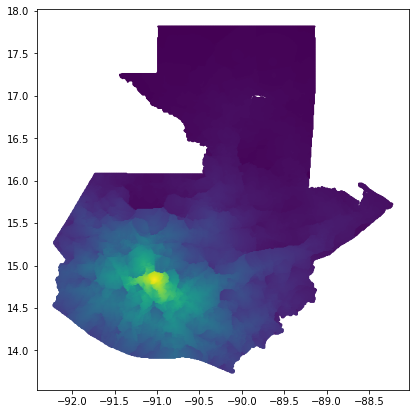

In [47]:
access_cities_results.plot(column='d_7', figsize=(7,7), markersize=1)

In [48]:
for d in range(5,10):
    print(f'writing {d}')
    aggregator.rasterize_gdf(access_cities_results, f'd_{d}', template=raster_path, outFile=os.path.join(output_path,f"access_cities_d{d}.tif"))

writing 5
writing 6
writing 7
writing 8
writing 9


### Make rasters of min travel time to each dest

In [49]:
output_path = os.path.join(out_folder, "travel_time")
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [50]:
# CHECK THAT MOST POPULATED CITY IS THE CAPITAL
cap_idx = dest_all.sort_values('Pop', ascending=False).iloc[[0]].index[0]

In [51]:
city_min = pd.DataFrame(origins_join2['city'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_city"])
ports_min = pd.DataFrame(origins_join2['port'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_port"])
airports_min = pd.DataFrame(origins_join2['airport'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_airport"])
borders_min = pd.DataFrame(origins_join2['border'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_border"])
capital_tt = origins_join2['city'].loc[:,[cap_idx]].apply(lambda x: (x/3600)).rename(columns={cap_idx:'tt_capital'})

In [52]:
origins_tt = origins_snapped.join([city_min, ports_min, airports_min, borders_min, capital_tt])

In [53]:
aggregator.rasterize_gdf(origins_tt, 'tt_city', raster_path, os.path.join(output_path,f"cities_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_port', raster_path, os.path.join(output_path,f"port_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_airport', raster_path, os.path.join(output_path,f"airport_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_border', raster_path, os.path.join(output_path,f"borders_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_capital', raster_path, os.path.join(output_path,f"capital_tt.tif"))